In [1]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [3]:
%matplotlib inline

In [4]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2021-02-25 15:17:00.939057


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d4562c18-3d01-4110-d707-48b82ba5de9d)
GPU 1: Tesla V100-SXM2-16GB (UUID: GPU-9c44e4aa-2342-c342-437b-2f435f4aa581)
GPU 2: Tesla V100-SXM2-16GB (UUID: GPU-5da48514-1b80-9761-08a6-1818f6a51f67)
GPU 3: Tesla V100-SXM2-16GB (UUID: GPU-81adc8d7-7c25-3e6b-e732-d72679baf578)


In [8]:
from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *

import make_models
reload(make_models)
from make_models import *

# Make tqdm work for colab
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [9]:
#%tensorflow_version 2.x
import tensorflow as tf
import timeit,pickle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.2533850474283099
GPU (s):
0.03229890391230583
GPU speedup over CPU: 7x


In [10]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

import pandas as pd
from sklearn.metrics import silhouette_score

#from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:20.567809


In [11]:
cd ../

/mmfs1/data/aglinska/BC-MRI-AE


In [12]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [13]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [14]:
aa

array([False, False, False, ..., False, False, False])

In [15]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [16]:
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [17]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [18]:
# Get Scanner Types and Scanning Site
#df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2 = pd.read_csv('/mmfs1/data/aglinska/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [19]:
df['ScanSite'] = [val.split('/')[6] for val in df2['sub_path'].values]
df['ScannerType'] = [val.split('/')[8] for val in df2['sub_path'].values]

In [20]:
df['ScannerID'] = str_to_ordinal(df['ScannerType'].values)
df['ScanSiteID'] = str_to_ordinal(df['ScanSite'].values)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2


In [21]:
print(df.shape)
print(ABIDE_data.shape)

(982, 83)
(982, 64, 64, 64)


In [22]:
# dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
# dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend.csv'
# #np.savez_compressed(dataFnOut,data=ABIDE_data)
# df.to_csv(dfFnOut)

In [23]:
train_vae = False

In [24]:
if train_vae:
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform

def plot_recon_vae():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [25]:
import pickle
if train_vae:
    latent_dim=32
    batch_size=64
    disentangle=False
    gamma=1
    
    encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
    loss = list()
    print('ready')
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan4th'
    fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/VAE_2D_b64_NoDis_g1'
    if os.path.exists(fn+'_loss.pickle'):
        print('loading weights')
        vae.load_weights(fn)
        loss = pickle.load(open(fn+'_loss.pickle','rb'))
    else:
        print('no weights found - initializing new')
        
    print(fn)


In [26]:
if train_vae:
    im1 = ABIDE_data[0:5,:,:,:][0,32,:,:];
    im = vae.predict(ABIDE_data[0:5,:,:,:])[0,32,:,:,0];
    plot_trainProgress(loss,im,im1);

In [27]:
if train_vae:
    batch_size = 64
    for i in tqdm(range(1,10000)):    
        history = vae.train_on_batch(ABIDE_data[np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size),:,:,:]);
        loss.append(history);
        if np.mod(i,25)==0:
            im1 = ABIDE_data[0:5,:,:,:][0,32,:,:];
            im = vae.predict(ABIDE_data[0:5,:,:,:])[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,100)==0:
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)


In [28]:
train_cvae=True


In [29]:
items = get_weights(fdir=None)

00 | 16dim_noDis_evBatch
01 | Feb03_1459_D16B1G100_DTrue
02 | Feb04_0524_D16B1G100_DTrue
03 | Feb05_0908_D16B1G100_DTrue
04 | Feb23_1049_D16B1G1_DTrue
05 | Feb23_1400_D2B1G100_DTrue
06 | Feb23_1551_D16B1G100_DTrue
07 | Feb_3d_16D_Dis_fixed
08 | Jan12_disentagled_l16
09 | Jan24_d16_dis_flipped_b5g20
10 | Jan24_d16_dis_flipped_b5g20_earlyStop
11 | Jan4th
12 | checkpoint
13 | fake_abide
14 | fake_abide_flipped
15 | fake_abide_flipped_disentangled
16 | play
17 | play_FLIP_3d_dis
18 | play_flip_3d_dis
19 | play_noflip
20 | test_fakeabide
21 | test_fakeabide_noDis


In [ ]:
if train_cvae:
    latent_dim = 16
    batch_size = 32
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
    fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
    #fn = 'Feb04_0524_D16B1G100_DTrue'
    #fn = 'Feb04_0524_D16B1G100_DTrue'
    
    fn = os.path.join(fdir,fn)
    fn = os.path.join(fdir,items[2])
    
    if os.path.exists(fn+'_loss.pickle'):
        loss = pickle.load(open(fn+'_loss.pickle','rb'))
        cvae.load_weights(fn)
        print('weights loaded')
    else:
        print('new model')
        

# Initial Check
import helper_funcs;reload(helper_funcs);from helper_funcs import *
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

print(fn)

'/mmfs1/data/aglinska/tf_outputs/CVAE/Feb04_0524_D16B1G100_DTrue_continued'

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

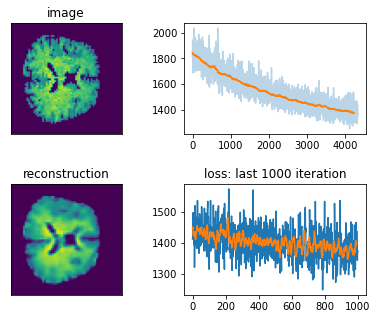

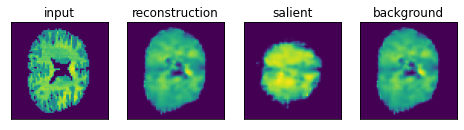

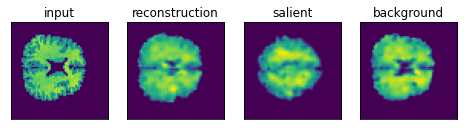

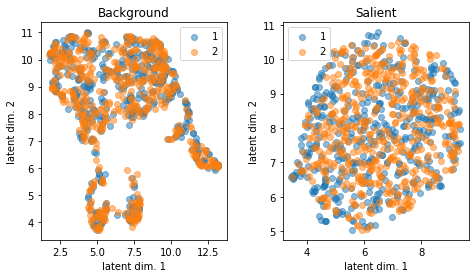

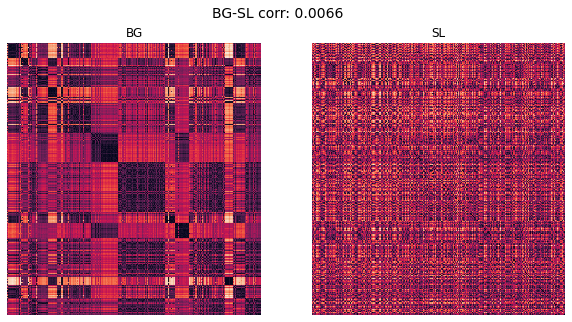

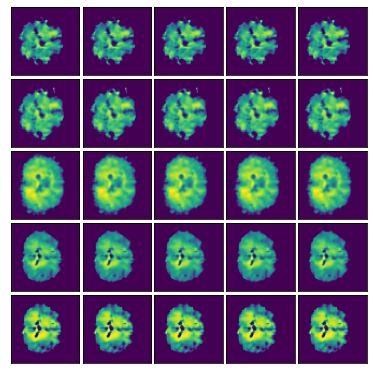

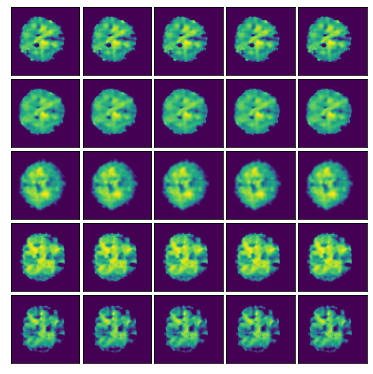

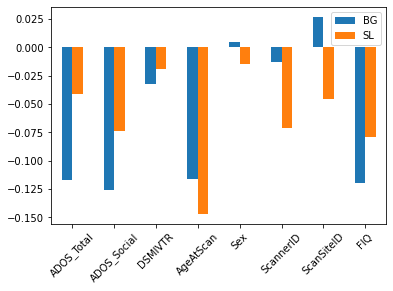

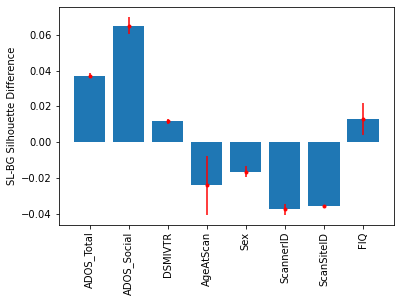

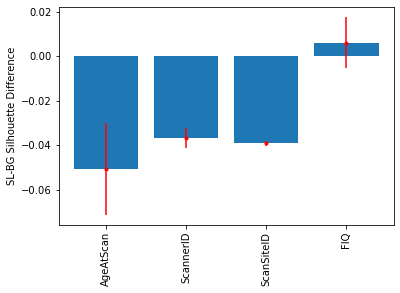

  1%|          | 5306/999999 [1:52:21<351:02:28,  1.27s/it] 


KeyboardInterrupt: 

In [39]:
import helper_funcs;reload(helper_funcs);from helper_funcs import *

for i in tqdm(range(1,int(1e6))):
    
    #asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
    #DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
    #TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)
    DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
    TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
    #print(TD_batch.shape)
    hist = cvae.train_on_batch([DX_batch,TD_batch]); # Proper 
    #hist = cvae.train_on_batch([TD_batch,DX_batch]); # Flipped
    
    assert not np.isnan(hist),'loss is NaN - you f**cked up'
    
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    
    loss.append(hist);
    
    if np.mod(i,100)==0:
        plot_trainProgress(loss,im,im1);
        pickle.dump(loss,open(fn+'_loss.pickle','wb'))
        plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
        plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)
        bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2)
        cscatter([bg_space,sl_space],c=df['DxGroup'].values)
        
        fig,ax = plt.subplots(1,2,figsize=(10,5));
        sns.heatmap(make_RDM(bg_space),ax=ax[0],xticklabels=[],yticklabels=[],cbar=False);ax[0].set_title('BG')
        sns.heatmap(make_RDM(sl_space),ax=ax[1],xticklabels=[],yticklabels=[],cbar=False);ax[1].set_title('SL')
        fig.suptitle(f'BG-SL corr: {np.corrcoef((get_triu(make_RDM(bg_space)),get_triu(make_RDM(sl_space))))[0,1]:.4f}',fontsize=14);
        fig.show()

        plt.figure(figsize=(5,5))
        plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='z', l=5)
        plt.show()

        plt.figure(figsize=(5,5))
        plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder,wspace='s', l=5)
        plt.show()
        
        plot_cvae_silhouettes(ABIDE_data,z_encoder,s_encoder,df,patients,keys=None,l=8)
        
        plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,df,patients)
        plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,df,controls,keys = ['AgeAtScan','ScannerID','ScanSiteID','FIQ'])
        
    if np.mod(i,101)==0:
        cvae.save_weights(fn)